In [1]:
import tensorflow as tf

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 


#building all kinds of evaluating parameters
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score  
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.metrics import confusion_matrix 

from sklearn.preprocessing import RobustScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Text(0, 0.5, 'Loss')

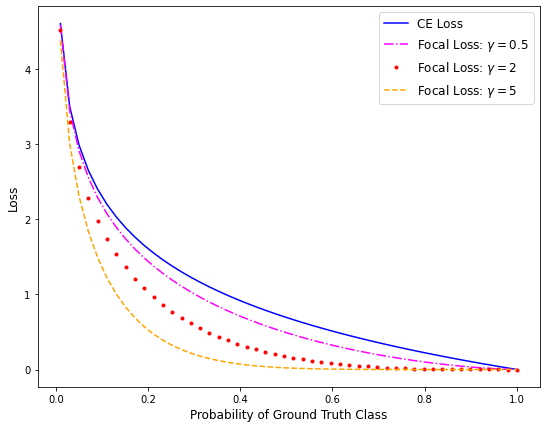

In [ ]:
p = np.linspace(0.01, 1.0, 50)
# print (p)
logp = -np.log(p)
ones = np.ones(len(p))
def fterm(gamma):
  return (ones - p)**(gamma)

fl2 = fterm(2) * logp

fl0 = fterm(0) * logp
fl5 = fterm(5) * logp
fl0d5 = fterm(0.5) * logp

fig=plt.figure(figsize=(9, 7))
plt.plot(p, logp, 'b-', label='CE Loss')

plt.plot(p, fl0d5, linestyle='-.', color='magenta', label=r'Focal Loss: $\gamma=0.5$')
plt.plot(p, fl2, 'r.', label=r'Focal Loss: $\gamma=2$')
plt.plot(p, fl5, linestyle='--', color='orange', label=r'Focal Loss: $\gamma=5$')
# plt.text(0.1, 4, )
plt.legend(fontsize=12)
plt.xlabel('Probability of Ground Truth Class', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# print (fterm(2))
# plt.savefig('/content/drive/My Drive/Colab Notebooks/Focal_Loss.png', dpi=200)

In [ ]:
credit_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/creditcard.csv', sep=',')
credit_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
print ('dataframe shape: ', credit_df.shape)

dataframe shape:  (284807, 31)


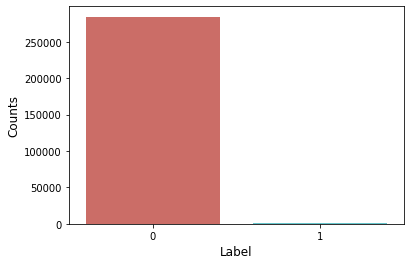

In [ ]:
# check the label distribution 

sns.countplot(x='Class', data=credit_df, palette='hls')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.show()

we see here extremely imbalanced data in action here. Fradulent cases are negligible and that's why it gets difficult to identify the fraud cases ... 

In [ ]:
print ('Cases without frauds: ', len(credit_df[credit_df['Class']==0]))
print ('Cases with frauds: ', len(credit_df[credit_df['Class']==1]))

Cases without frauds:  284315
Cases with frauds:  492


In [ ]:
print ('check for null values in each column: ', credit_df.isna().sum())

check for null values in each column:  Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


No null values in the data-frame!! 

If you see values in the respective columns, _Amount_ and _Time_ are not scaled but other columns are scaled. So to include Amount and Time as features we need to scale them. 
Here we can use StandardScaler/RobustScaler to scale these features.   

In [ ]:
## Scale Amount and Time 

robust_scaler = RobustScaler()

credit_df[['Amount', 'Time']] = robust_scaler.fit_transform(credit_df[['Amount', 'Time']])

credit_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0


In [ ]:
X_labels = credit_df.drop(['Class'], axis=1)
y_labels = credit_df['Class']

print ('x shape and type: ', X_labels.shape, type(X_labels))
print ('y shape: ', y_labels.shape)

X_labels = X_labels.to_numpy(dtype=np.float64)
y_labels = y_labels.to_numpy(dtype=np.float64)

print ('x shape and type: ', X_labels.shape, type(X_labels))

print ('check few yvals: ', y_labels[0:3])

y_lab_cat = tf.keras.utils.to_categorical(y_labels, num_classes=2, dtype='float32')

print ('categorical y_lab: ', y_lab_cat[0:3])

x shape and type:  (284807, 30) <class 'pandas.core.frame.DataFrame'>
y shape:  (284807,)
x shape and type:  (284807, 30) <class 'numpy.ndarray'>
check few yvals:  [0. 0. 0.]
categorical y_lab:  [[1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_labels, y_lab_cat, test_size=0.3, 
                                                    stratify=y_lab_cat, shuffle=True)


# stratify ensure same proportion of class labels

print('train data shape and type: ', x_train.shape, type(x_train))
print ('test data shape: ', x_test.shape)

print ('check few y vals: ', y_train[0:3])

train data shape and type:  (199364, 30) <class 'numpy.ndarray'>
test data shape:  (85443, 30)
check few y vals:  [[1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
from tensorflow.keras.layers import  Dense, Input, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations 
from tensorflow import keras

from keras import backend as K

In [ ]:
def simple_model():
  input_data  = Input(shape=(x_train.shape[1], ))
  x = Dense(64)(input_data)
  x = Activation(activations.relu)(x)
  x = Dense(32)(x)
  x = Activation(activations.relu)(x)
  x = Dense(2)(x)
  x = Activation(activations.softmax)(x)

  model = Model(inputs=input_data, outputs=x, name='Simple_Model')

  return model  

In [ ]:
def simple_model1():
  input_data  = Input(shape=(x_train.shape[1], ))
  x = Dense(64)(input_data)
  x = Activation(activations.relu)(x)
  x = Dense(32)(x)
  x = Activation(activations.relu)(x)
  x = Dense(2)(x)
  x = Activation(activations.softmax)(x)

  model = Model(inputs=input_data, outputs=x, name='Simple_Model')

  return model  

In [ ]:
simple_model = simple_model()
simple_model.summary()

In [ ]:
# simple_model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', 
#                       metrics=['acc'])

simple_model.compile(optimizer=Adam(learning_rate=5e-3), loss='categorical_crossentropy', 
                      metrics=['acc'])

In [ ]:
simple_model.fit(x_train, y_train, validation_split=0.2, epochs=5, shuffle=True, batch_size=256)

Epoch 1/5
624/624 [==============================] - 2s 2ms/step - loss: 0.0393 - acc: 0.9834 - val_loss: 0.0034 - val_acc: 0.9994
Epoch 2/5
624/624 [==============================] - 1s 2ms/step - loss: 0.0028 - acc: 0.9995 - val_loss: 0.0032 - val_acc: 0.9995
Epoch 3/5
624/624 [==============================] - 1s 2ms/step - loss: 0.0027 - acc: 0.9994 - val_loss: 0.0028 - val_acc: 0.9994
Epoch 4/5
624/624 [==============================] - 1s 2ms/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0029 - val_acc: 0.9995
Epoch 5/5
624/624 [==============================] - 1s 2ms/step - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0034 - val_acc: 0.9992


In [ ]:
def conf_matrix(predictions, class_types, y_test_argmax=False): 
    ''' Plots conf. matrix and classification report '''
    if y_test_argmax==True:
      cm=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(np.round(predictions), axis=1))
      cr=classification_report(np.argmax(y_test, axis=1),
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
      print(cr)
    else:
      cm=confusion_matrix(y_test, np.argmax(np.round(predictions), axis=1))
      print("Classification Report:\n")
      cr=classification_report(y_test,
                                  np.argmax(np.round(predictions), axis=1), 
                                  target_names=[class_types[i] for i in range(len(class_types))])
      print(cr)
    plt.figure(figsize=(6,6))
    
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d", cmap="YlGnBu")
    
    plt.xlabel('Pred Class')
    plt.ylabel('True Class')
    fig = sns_hmp.get_figure()
    # fig.savefig('/content/gdrive/My Drive/Colab Notebooks/resnet/heatmap.png', dpi=250)

In [ ]:
y_pred = simple_model.predict(x_test, batch_size=64)

# y_pred_argmax = np.argmax(y_pred, axis=1)

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00     85295
       Fraud       0.87      0.47      0.61       148

    accuracy                           1.00     85443
   macro avg       0.94      0.73      0.80     85443
weighted avg       1.00      1.00      1.00     85443



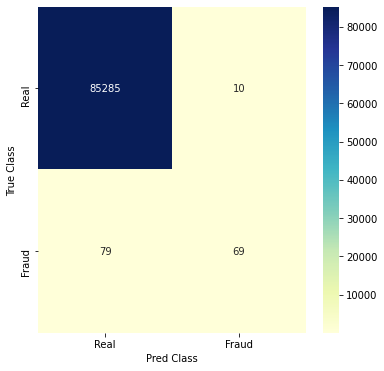

In [ ]:
conf_matrix(y_pred, ['Real', 'Fraud'], y_test_argmax=True)

In [ ]:
print ('check first 3 y pred: ', y_pred[0:3])
print ('check first 3 y_test: ', y_test[0:3])
print ('check argmax of pred:',  np.argmax(np.round(y_pred[0:3]), axis=1))

check first 3 y pred:  [[9.9999940e-01 5.8592815e-07]
 [9.9996805e-01 3.1988002e-05]
 [9.9940896e-01 5.9102214e-04]]
check first 3 y_test:  [[1. 0.]
 [1. 0.]
 [1. 0.]]
check argmax of pred: [0 0 0]


### Focal Loss: 

We will see that cross-entropy loss is a special case of Focal loss. 

Definition : 

$\text{FL}(p_t) = - \alpha _t \, \left(1-p_t\right)^{\gamma}\, \text{log}(p_t)$

$$\begin{equation}p_t = \begin{cases}p\, ; & \text{if}\, \, y = 1 \\ 1-p\, ; & \text{otherwise} \end{cases} \end{equation}$$

When $\gamma = 0, \alpha _t = 1$, then FL is Cross Entropy loss.  

In [3]:
## how does it affect ? 

y_example_true = [1.0]
y_example_pred = [0.90]
y_example_pred0 = [0.95]
y_example_pred1 = [0.20]

binary_ce = tf.keras.losses.BinaryCrossentropy()
loss_close = binary_ce(y_example_true, y_example_pred).numpy()
loss_veryclose = binary_ce(y_example_true, y_example_pred0).numpy()
loss_far = binary_ce(y_example_true, y_example_pred1).numpy()

print ('CE loss when pred is close to true: ', loss_close)
print ('CE loss when pred is very close to true: ', loss_veryclose)
print ('CE loss when pred is far from true: ', loss_far)

focal_factor_close = (1.0-0.90)**2 ## (take gamma = 2, as in paper)
focal_factor_veryclose = (1.0-0.95)**2
focal_factor_far = (1.0-0.20)**2 ## ()

print ('\n')

print ('focal loss when pred is close to true: ', loss_close*focal_factor_close)
print ('focal loss when pred is very close to true: ', loss_veryclose*focal_factor_veryclose)

print ('focal loss when pred is far from true: ', loss_far*focal_factor_far)

CE loss when pred is close to true:  0.10536041
CE loss when pred is very close to true:  0.051293183
CE loss when pred is far from true:  1.6094373


focal loss when pred is close to true:  0.0010536041110754007
focal loss when pred is very close to true:  0.00012823295779526255
focal loss when pred is far from true:  1.0300399017333985


Penalize way more when prediction is far from true, i.e. focus on the wrongly classified samples

In [ ]:
import tensorflow_addons as tfa 

In [ ]:
fl_tensorflow = tfa.losses.SigmoidFocalCrossEntropy(alpha=1.0, gamma=2.0)
fl_close = fl_tensorflow(y_example_true, y_example_pred).numpy()
fl_far = fl_tensorflow(y_example_true, y_example_pred1).numpy()

print ('check values: ', fl_close, fl_far)

check values:  0.008925734 1.03004


Custom loss function 

In [ ]:
def focal_loss_custom(alpha, gamma):
  def binary_focal_loss(y_true, y_pred):

    fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
    # pred_argmax = np.argmax(np.round(y_pred), axis=1)
    # pred_argmax_tensor = tf.convert_to_tensor(pred_argmax, dtype=tf.float32)
    # y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_true_K = K.ones_like(y_true)
    focal_loss = fl(y_true, y_pred)
    # focal_loss = tf.reduce_mean(focal_loss)
    return focal_loss
  return binary_focal_loss  

In [ ]:
simple_model1 = simple_model1()
simple_model1.compile(optimizer=Adam(learning_rate=5e-3), loss=focal_loss_custom(alpha=0.2, gamma=2.0), metrics=['acc'])

In [ ]:
simple_model1.fit(x_train, y_train, validation_split=0.2, epochs=5, shuffle=True, batch_size=256)

Epoch 1/5
624/624 [==============================] - 2s 2ms/step - loss: 0.0135 - acc: 0.9844 - val_loss: 0.0012 - val_acc: 0.9993
Epoch 2/5
624/624 [==============================] - 1s 2ms/step - loss: 8.6970e-04 - acc: 0.9994 - val_loss: 0.0013 - val_acc: 0.9991
Epoch 3/5
624/624 [==============================] - 1s 2ms/step - loss: 8.5765e-04 - acc: 0.9994 - val_loss: 0.0011 - val_acc: 0.9993
Epoch 4/5
624/624 [==============================] - 1s 2ms/step - loss: 7.4777e-04 - acc: 0.9994 - val_loss: 0.0012 - val_acc: 0.9993
Epoch 5/5
624/624 [==============================] - 1s 2ms/step - loss: 8.3562e-04 - acc: 0.9994 - val_loss: 0.0012 - val_acc: 0.9993


In [ ]:
y_pred = simple_model1.predict(x_test, batch_size=32)


In [ ]:
confusion_matrix(np.argmax(y_test, axis=1), np.argmax(np.round(y_pred), axis=1))

array([[85289,     6],
       [   47,   101]])

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00     85295
       Fraud       0.94      0.68      0.79       148

    accuracy                           1.00     85443
   macro avg       0.97      0.84      0.90     85443
weighted avg       1.00      1.00      1.00     85443



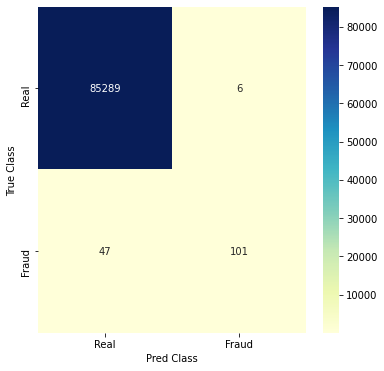

In [ ]:
conf_matrix(y_pred, ['Real', 'Fraud'], y_test_argmax=True)

In [ ]:
print ('check first 3 ypred: ', y_pred[0:4])
print ('check first 3 ytest: ', y_test[0:4])

print (np.argmax(np.round(y_pred[0:4]), axis=1))

print (tf.cast(y_test[0:4], dtype=tf.float32))
print (K.ones_like(y_test[0:4]))

check first 3 ypred:  [[0.9667234  0.03327663]
 [0.9822015  0.01779843]
 [0.99318063 0.00681934]
 [0.9779823  0.02201766]]
check first 3 ytest:  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[0 0 0 0]
tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]], shape=(4, 2), dtype=float32)
